In [297]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests

from datetime import datetime, timedelta

import folium
from folium.plugins import HeatMap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

import joblib

pd.set_option('display.expand_frame_repr', False)

In [298]:
# # Define the API endpoint
# URL = "https://api.data.gov.sg/v1/transport/taxi-availability"

# # Create a list of timestamps for the past 30 days (hourly intervals)
# current_date = datetime.now()
# start_date = (current_date - timedelta(days=1)).replace(hour=0, minute=59, second=0, microsecond=0)

# # Generate a list of timestamps at hourly intervals
# timestamps = pd.date_range(start=start_date, end=current_date, freq='h')

In [299]:
# # List to store the data
# taxi_data = []

# # Loop through each timestamp and retrieve data
# for timestamp in timestamps:
#     # Convert the timestamp to the required format
#     date_time_str = timestamp.strftime('%Y-%m-%dT%H:%M:%S')

#     # Define parameters for the API request
#     params = {
#         "date_time": date_time_str
#     }

#     # Send the GET request
#     response = requests.get(URL, params=params)

#     # Check if the request was successful
#     if response.status_code == 200:
#         data = response.json()
#         features = data["features"]
        
#         for feature in features:
#             coordinates = feature["geometry"]["coordinates"]
#             taxi_count = feature["properties"]["taxi_count"]
#             request_time = feature["properties"]["timestamp"]

#             for coordinate in coordinates:
#                 taxi_data.append({
#                     "timestamp": request_time,
#                     "taxi_count": taxi_count,
#                     "longitude": coordinate[0],
#                     "latitude": coordinate[1]
#                 })
#     else:
#         print(f"Failed to retrieve data for {date_time_str}. Status code: {response.status_code}")

# # Convert the list to a DataFrame
# df = pd.DataFrame(taxi_data)

# # Save the data to CSV for further analysis
# df.to_csv('taxi_availability_yesterday.csv', index=False)

# # Display a sample of the data
# print(df.head())

In [300]:
taxi_df = pd.read_csv('taxi_availability_yesterday.csv')
print(taxi_df.head(), '\n')
print(taxi_df.info(), '\n')
print(taxi_df.tail())

                   timestamp  taxi_count  longitude  latitude
0  2024-10-21T00:58:33+08:00        1757  103.63322   1.27390
1  2024-10-21T00:58:33+08:00        1757  103.63719   1.34000
2  2024-10-21T00:58:33+08:00        1757  103.64739   1.32286
3  2024-10-21T00:58:33+08:00        1757  103.64918   1.33688
4  2024-10-21T00:58:33+08:00        1757  103.66653   1.29757 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107132 entries, 0 to 107131
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   timestamp   107132 non-null  object 
 1   taxi_count  107132 non-null  int64  
 2   longitude   107132 non-null  float64
 3   latitude    107132 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.3+ MB
None 

                        timestamp  taxi_count  longitude  latitude
107127  2024-10-22T22:58:15+08:00        2795  104.00063   1.38102
107128  2024-10-22T22:58:15+08:00        2795  104.00098   1.

In [301]:
# Extracting longitude and latitude
location_data = taxi_df[['longitude', 'latitude']].values

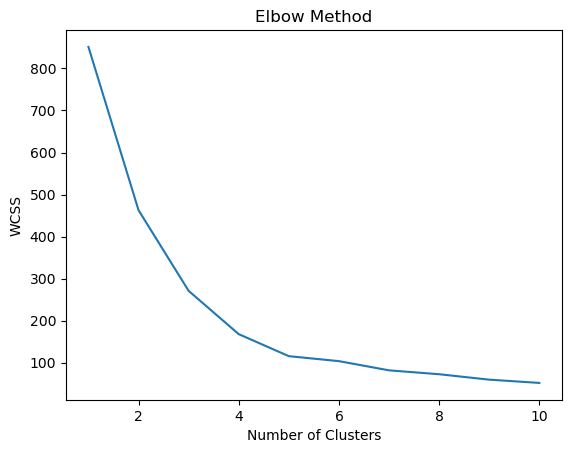

In [302]:
# Choosing an optimal number of clusters from a range between 1 and 10 using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(location_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [303]:
optimal_k = 5
kmeans = KMeans(n_clusters = optimal_k, init = 'k-means++', random_state = 42)
taxi_df['assigned_cluster_id'] = kmeans.fit_predict(location_data)

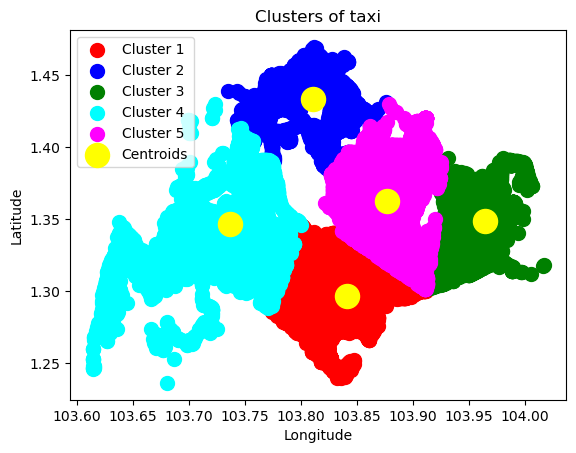

In [304]:
y_kmeans = taxi_df['assigned_cluster_id']
plt.scatter(location_data[y_kmeans == 0, 0], location_data[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(location_data[y_kmeans == 1, 0], location_data[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(location_data[y_kmeans == 2, 0], location_data[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(location_data[y_kmeans == 3, 0], location_data[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(location_data[y_kmeans == 4, 0], location_data[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of taxi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [305]:
kmeans.cluster_centers_

array([[103.84060144,   1.2964135 ],
       [103.81084959,   1.43336548],
       [103.96400117,   1.349013  ],
       [103.73671902,   1.34640529],
       [103.87684715,   1.36289866]])

In [306]:
for index, row in taxi_df.iterrows():
    if row['assigned_cluster_id'] == 0:
        taxi_df.at[index, 'cluster_id'] = 0
    elif row['assigned_cluster_id'] == 1:
        taxi_df.at[index, 'cluster_id'] = 4
    elif row['assigned_cluster_id'] == 2:
        taxi_df.at[index, 'cluster_id'] = 2
    elif row['assigned_cluster_id'] == 3:
        taxi_df.at[index, 'cluster_id'] = 1
    elif row['assigned_cluster_id'] == 4:
        taxi_df.at[index, 'cluster_id'] = 3

In [307]:
taxi_df

,timestamp,taxi_count,longitude,latitude,assigned_cluster_id,cluster_id
0,2024-10-21T00:58:33+08:00,1757,103.63322,1.27390,3,1.0
1,2024-10-21T00:58:33+08:00,1757,103.63719,1.34000,3,1.0
2,2024-10-21T00:58:33+08:00,1757,103.64739,1.32286,3,1.0
3,2024-10-21T00:58:33+08:00,1757,103.64918,1.33688,3,1.0
4,2024-10-21T00:58:33+08:00,1757,103.66653,1.29757,3,1.0
...,...,...,...,...,...,...
107127,2024-10-22T22:58:15+08:00,2795,104.00063,1.38102,2,2.0
107128,2024-10-22T22:58:15+08:00,2795,104.00098,1.38017,2,2.0
107129,2024-10-22T22:58:15+08:00,2795,104.00129,1.37802,2,2.0
107130,2024-10-22T22:58:15+08:00,2795,104.00225,1.37598,2,2.0


In [308]:
taxi_df['cluster_id'] = taxi_df['cluster_id'].astype(int)
taxi_df.drop('assigned_cluster_id', axis='columns', inplace=True)
taxi_df

,timestamp,taxi_count,longitude,latitude,cluster_id
0,2024-10-21T00:58:33+08:00,1757,103.63322,1.27390,1
1,2024-10-21T00:58:33+08:00,1757,103.63719,1.34000,1
2,2024-10-21T00:58:33+08:00,1757,103.64739,1.32286,1
3,2024-10-21T00:58:33+08:00,1757,103.64918,1.33688,1
4,2024-10-21T00:58:33+08:00,1757,103.66653,1.29757,1
...,...,...,...,...,...
107127,2024-10-22T22:58:15+08:00,2795,104.00063,1.38102,2
107128,2024-10-22T22:58:15+08:00,2795,104.00098,1.38017,2
107129,2024-10-22T22:58:15+08:00,2795,104.00129,1.37802,2
107130,2024-10-22T22:58:15+08:00,2795,104.00225,1.37598,2


In [309]:
# Convert timestamp to datetime and extract relevant time features
taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'])
taxi_df['hour'] = taxi_df['timestamp'].dt.hour
taxi_df['date'] = taxi_df['timestamp'].dt.date
taxi_df['day_of_week'] = taxi_df['timestamp'].dt.weekday

cluster_data = taxi_df.groupby(['date', 'hour', 'day_of_week', 'cluster_id']).size().reset_index(name='num_taxis_available')

In [310]:
print('Timestamp (hour): ', cluster_data['hour'].unique().tolist())
print('Cluster ID: ', cluster_data['cluster_id'].unique().tolist())

Timestamp (hour):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Cluster ID:  [0, 1, 2, 3, 4]


In [311]:
cluster_data

,date,hour,day_of_week,cluster_id,num_taxis_available
0,2024-10-21,0,0,0,419
1,2024-10-21,0,0,1,303
2,2024-10-21,0,0,2,299
3,2024-10-21,0,0,3,462
4,2024-10-21,0,0,4,274
...,...,...,...,...,...
230,2024-10-22,22,1,0,871
231,2024-10-22,22,1,1,420
232,2024-10-22,22,1,2,643
233,2024-10-22,22,1,3,575


In [312]:
# Create lag features
lags = [1, 2, 3, 24]  # Lag of 1 hour, 2 hours, 3 hours
for lag in lags:
    cluster_data[f'lag_{lag}'] = cluster_data.groupby('cluster_id')['num_taxis_available'].shift(lag)

In [313]:
cluster_data['cluster_id'] = cluster_data['cluster_id'].astype(int)

cluster_data

,date,hour,day_of_week,cluster_id,num_taxis_available,lag_1,lag_2,lag_3,lag_24
0,2024-10-21,0,0,0,419,NaN,NaN,NaN,NaN
1,2024-10-21,0,0,1,303,NaN,NaN,NaN,NaN
2,2024-10-21,0,0,2,299,NaN,NaN,NaN,NaN
3,2024-10-21,0,0,3,462,NaN,NaN,NaN,NaN
4,2024-10-21,0,0,4,274,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
230,2024-10-22,22,1,0,871,629.0,848.0,939.0,760.0
231,2024-10-22,22,1,1,420,442.0,411.0,441.0,389.0
232,2024-10-22,22,1,2,643,671.0,593.0,636.0,729.0
233,2024-10-22,22,1,3,575,599.0,602.0,603.0,583.0


In [314]:
first_date = cluster_data['date'].min()
cluster_data_filtered = cluster_data[cluster_data['date'] > first_date].reset_index(drop=True)

In [315]:
cluster_data_filtered

,date,hour,day_of_week,cluster_id,num_taxis_available,lag_1,lag_2,lag_3,lag_24
0,2024-10-22,0,1,0,548,748.0,760.0,819.0,419.0
1,2024-10-22,0,1,1,343,340.0,389.0,416.0,303.0
2,2024-10-22,0,1,2,439,537.0,729.0,624.0,299.0
3,2024-10-22,0,1,3,510,520.0,583.0,519.0,462.0
4,2024-10-22,0,1,4,249,253.0,288.0,277.0,274.0
...,...,...,...,...,...,...,...,...,...
110,2024-10-22,22,1,0,871,629.0,848.0,939.0,760.0
111,2024-10-22,22,1,1,420,442.0,411.0,441.0,389.0
112,2024-10-22,22,1,2,643,671.0,593.0,636.0,729.0
113,2024-10-22,22,1,3,575,599.0,602.0,603.0,583.0


In [327]:
# Trial: Use lag_features for the hour of 22 to predict the num_taxis_available at this hour
current_time = datetime.now()
current_date = current_time.date()
current_day = current_time.weekday()
current_hour = current_time.hour - 1

# Retrieve lag features for the current hour
lag_current = cluster_data[(cluster_data['date'] == current_date) & (cluster_data['hour'] == current_hour)]

lag_current

,date,hour,day_of_week,cluster_id,num_taxis_available,lag_1,lag_2,lag_3,lag_24
230,2024-10-22,22,1,0,871,629.0,848.0,939.0,760.0
231,2024-10-22,22,1,1,420,442.0,411.0,441.0,389.0
232,2024-10-22,22,1,2,643,671.0,593.0,636.0,729.0
233,2024-10-22,22,1,3,575,599.0,602.0,603.0,583.0
234,2024-10-22,22,1,4,286,293.0,321.0,286.0,288.0


# Model Test

Clusters are as follow:

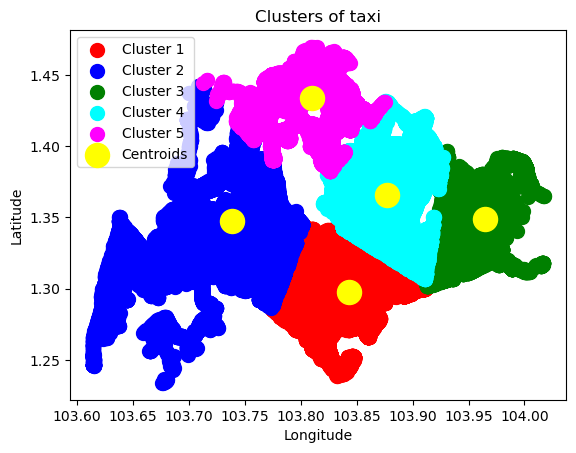

In [341]:
# Load the saved model
model = joblib.load('tuned_xgboost_model.pkl')

# Prepare the input data for prediction
# Use the relevant columns for prediction ('hour', 'day_of_week', 'lag_1', 'lag_2', 'lag_3', 'lag_24')
input_features = lag_current[['lag_1', 'lag_2', 'lag_3', 'lag_24', 'day_of_week', 'cluster_id']]

# Make predictions using the model
predictions = model.predict(input_features)

# Add predictions to the original DataFrame
lag_current['predicted_num_taxis'] = predictions.round()
lag_current['predicted_num_taxis'] = lag_current['predicted_num_taxis'].astype(int)
# Display the DataFrame with predictions
print(lag_current[['cluster_id', 'hour', 'day_of_week', 'predicted_num_taxis', 'num_taxis_available']].reset_index(drop=True))

   cluster_id  hour  day_of_week  predicted_num_taxis  num_taxis_available
0           0    22            1                  695                  871
1           1    22            1                  406                  420
2           2    22            1                  665                  643
3           3    22            1                  594                  575
4           4    22            1                  284                  286


/var/folders/j5/m90b2sqx6k9dr4l9ys0fgx300000gn/T/ipykernel_36432/648051006.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lag_current['predicted_num_taxis'] = predictions.round()
/var/folders/j5/m90b2sqx6k9dr4l9ys0fgx300000gn/T/ipykernel_36432/648051006.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lag_current['predicted_num_taxis'] = lag_current['predicted_num_taxis'].astype(int)


# Data Visualization

/var/folders/j5/m90b2sqx6k9dr4l9ys0fgx300000gn/T/ipykernel_36432/2856967653.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lag_current['percentage_diff'] = abs(lag_current['num_taxis_available'] - lag_current['predicted_num_taxis']) / lag_current['num_taxis_available'] * 100
/var/folders/j5/m90b2sqx6k9dr4l9ys0fgx300000gn/T/ipykernel_36432/2856967653.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data['cluster_id'] = heatmap_data['cluster_id'] + 1


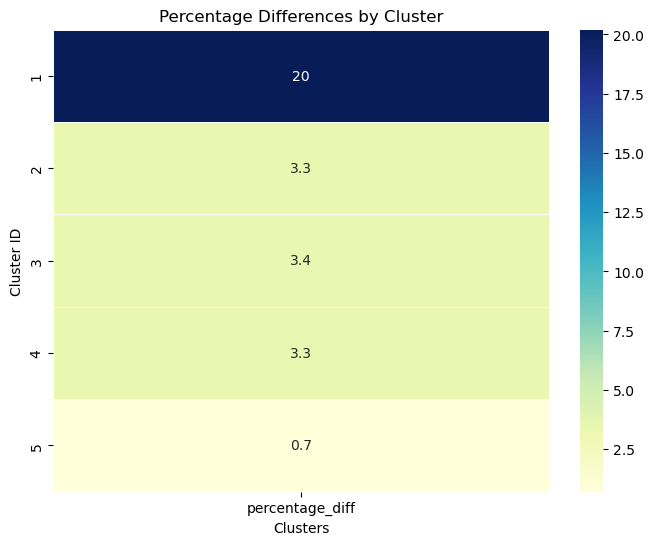

In [346]:
# Sample data (replace with your actual DataFrame)
# lag_current is assumed to have 'cluster_id', 'predicted_num_taxis', and 'num_taxis_available'

# Step 1: Calculate the Percentage Differences
lag_current['percentage_diff'] = abs(lag_current['num_taxis_available'] - lag_current['predicted_num_taxis']) / lag_current['num_taxis_available'] * 100

# Step 2: Prepare the Data for Heatmap
heatmap_data = lag_current[['cluster_id', 'percentage_diff']]
heatmap_data['cluster_id'] = heatmap_data['cluster_id'] + 1
# Step 3: Pivot the Data for the Heatmap
heatmap_pivot = heatmap_data.pivot_table(index='cluster_id', values='percentage_diff')

# Step 4: Create the Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_pivot, annot=True, cmap="YlGnBu", cbar=True, linewidths=.5)

plt.title('Percentage Differences by Cluster')
plt.xlabel('Clusters')
plt.ylabel('Cluster ID')
plt.show()

/var/folders/j5/m90b2sqx6k9dr4l9ys0fgx300000gn/T/ipykernel_36432/3176326739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_act_data['cluster_id'] = pred_act_data['cluster_id'] + 1


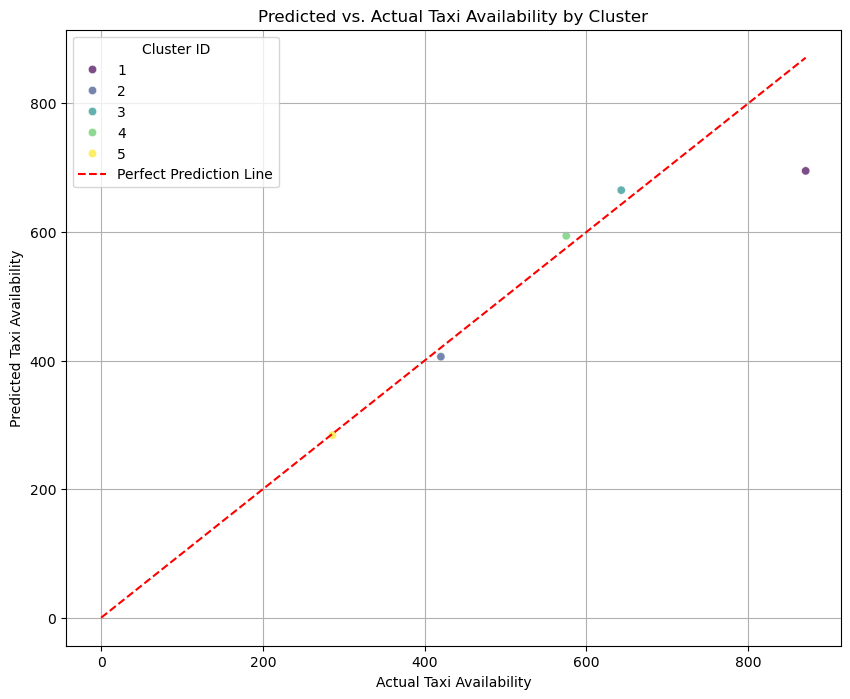

In [348]:
pred_act_data = lag_current[['cluster_id', 'num_taxis_available', 'predicted_num_taxis']]
pred_act_data['cluster_id'] = pred_act_data['cluster_id'] + 1

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pred_act_data,
    x='num_taxis_available',
    y='predicted_num_taxis',
    hue='cluster_id',  # Color points by cluster
    palette='viridis',
    alpha=0.7
)

# Plot the line of perfect predictions
max_value = max(lag_current['num_taxis_available'].max(), lag_current['predicted_num_taxis'].max())
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label='Perfect Prediction Line')

# Add labels and title
plt.xlabel('Actual Taxi Availability')
plt.ylabel('Predicted Taxi Availability')
plt.title('Predicted vs. Actual Taxi Availability by Cluster')
plt.legend(title='Cluster ID')
plt.grid(True)

# Show the plot
plt.show()
